# Predicting house prices

#### La predicción de precios de vivienda es un problema típico de regresión, donde el objetivo es predecir un valor continuo en lugar de una etiqueta discreta, a diferencia de los problemas de clasificación.

#### Se intenta predecir el precio medio de las viviendas en los suburbios de Boston en los años 70.

#### El conjunto de datos tiene 506 muestras, divididas en 404 para entrenamiento y 102 para test.

#### Cada muestra tiene 13 características numéricas, como tasa de criminalidad per cápita, número promedio de habitaciones por vivienda y accesibilidad a carreteras.

#### El rango de precios de las viviendas oscila entre \$10,000 y \$50,000 (sin ajuste por inflación).

## Importar librerías

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import boston_housing
from tensorflow import keras
from keras import layers

### Cargar datos

In [3]:
from tensorflow.keras.datasets import boston_housing
# Cargar los datos de Boston Housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

# Definir nombres de las características
column_names = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"]

# Crear DataFrames
df_train = pd.DataFrame(train_data, columns=column_names)
df_train["MEDV"] = train_targets  # Agregar columna objetivo

df_test = pd.DataFrame(test_data, columns=column_names)
df_test["MEDV"] = test_targets


## Explorar los datos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     404 non-null    float64
 1   ZN       404 non-null    float64
 2   INDUS    404 non-null    float64
 3   CHAS     404 non-null    float64
 4   NOX      404 non-null    float64
 5   RM       404 non-null    float64
 6   AGE      404 non-null    float64
 7   DIS      404 non-null    float64
 8   RAD      404 non-null    float64
 9   TAX      404 non-null    float64
 10  PTRATIO  404 non-null    float64
 11  B        404 non-null    float64
 12  LSTAT    404 non-null    float64
 13  MEDV     404 non-null    float64
dtypes: float64(14)
memory usage: 44.3 KB
None
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  404.000000  404.000000  404.000000  404.000000  404.000000  404.000000   
mean     3.745111   11.480198   11.104431    0.061881    0.557356    6.267082 

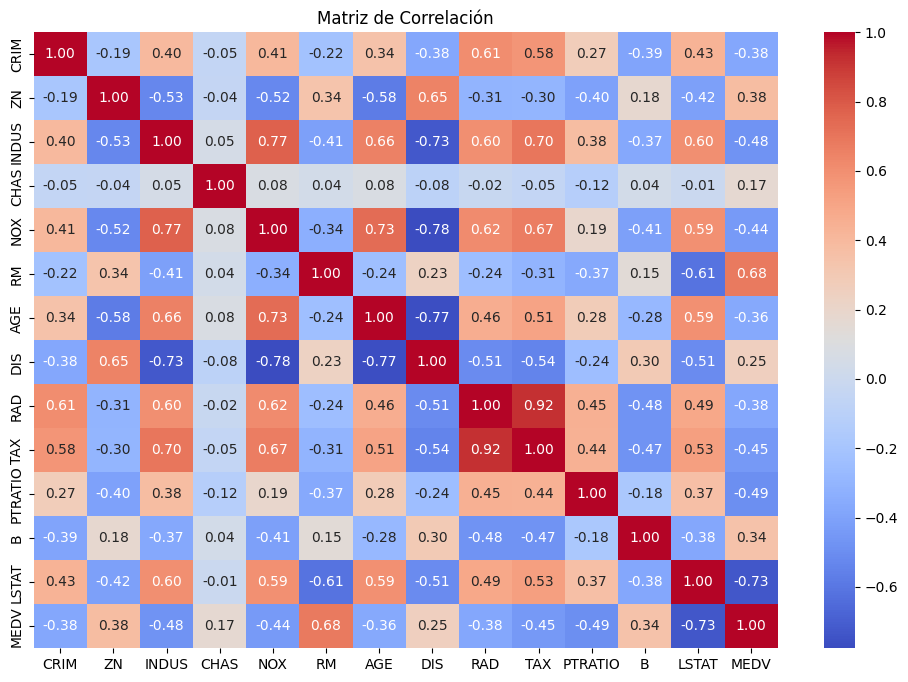

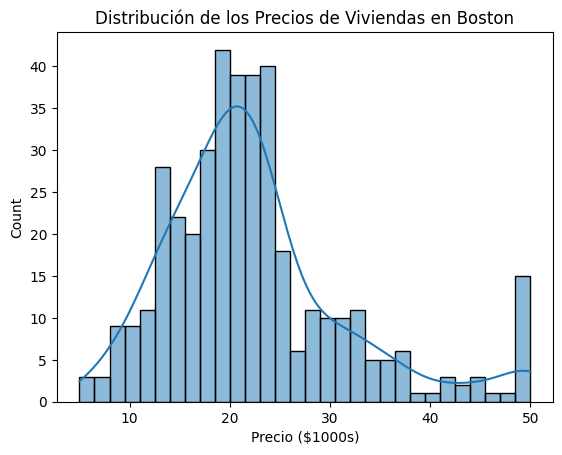

In [5]:
# Mostrar información general del conjunto de datos
print(df_train.info())

# Mostrar estadísticas descriptivas
print(df_train.describe())

# Visualizar la correlación entre características
plt.figure(figsize=(12, 8))
sns.heatmap(df_train.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

# Ver la distribución de precios de viviendas
sns.histplot(df_train["MEDV"], bins=30, kde=True)
plt.title("Distribución de los Precios de Viviendas en Boston")
plt.xlabel("Precio ($1000s)")
plt.show()

## Procesamiento de los datos
#### Debido a que las características tienen escalas muy diferentes, se recomienda normalizarlas:

In [6]:
# Normalizar los datos
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data = (train_data - mean) / std
test_data = (test_data - mean) / std


## Construcción del modelo
#### Se usa una red neuronal con dos capas intermedias de 64 neuronas y una capa de salida con una sola neurona (sin activación, para regresión).
#### El modelo usa MSE (Error Cuadrático Medio) como función de pérdida y MAE (Error Absoluto Medio) como métrica.


In [8]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu", input_shape=(train_data.shape[1],)),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)  # Capa de salida sin activación para regresión
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

model = build_model()

## Validación con K-fold
#### La validación cruzada K-Fold ayuda cuando hay pocos datos. Se divide el conjunto de entrenamiento en K subconjuntos, y el modelo se entrena varias veces usando cada fold como validación una vez.

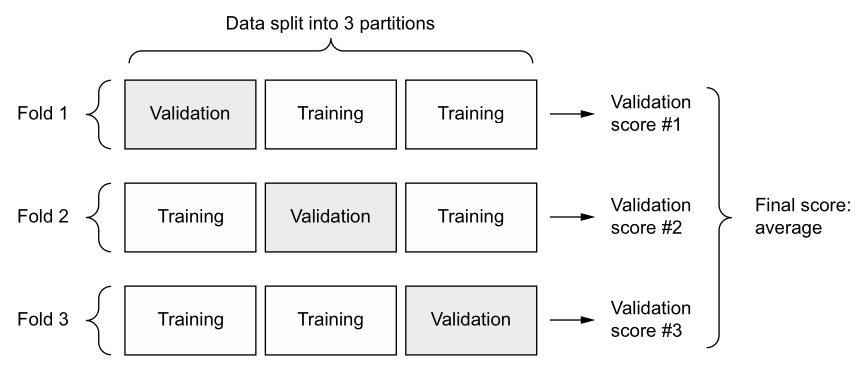

In [10]:
k = 4  # Número de folds
num_val_samples = len(train_data) // k  # Tamaño de cada fold
num_epochs = 100  # Número de épocas de entrenamiento
all_scores = []  # Para almacenar los resultados de validación

for i in range(k):
    print(f"Procesando fold #{i+1}")

    # Definir datos de validación
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # Definir datos de entrenamiento (excluyendo el fold de validación)
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    # Construir y entrenar el modelo
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
    
    # Evaluar en el fold de validación
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)


Procesando fold #1
Procesando fold #2
Procesando fold #3
Procesando fold #4


## Gráfico de resultados de la validación

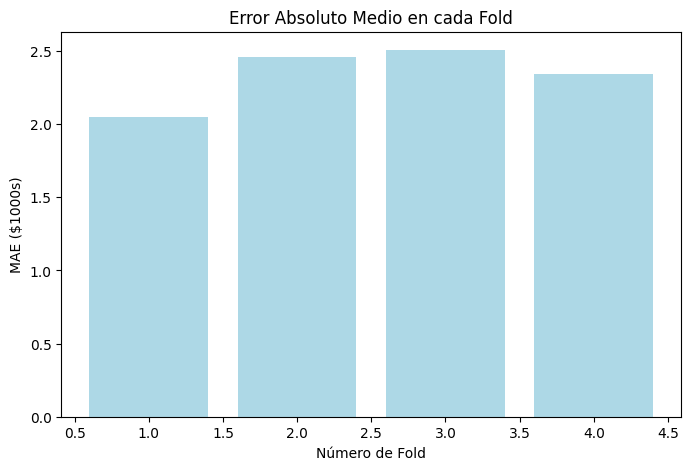

In [11]:
# Mostrar la variabilidad del error en los diferentes folds
plt.figure(figsize=(8, 5))
plt.bar(range(1, k+1), all_scores, color="lightblue")
plt.xlabel("Número de Fold")
plt.ylabel("MAE ($1000s)")
plt.title("Error Absoluto Medio en cada Fold")
plt.show()


## Generando predicciones

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
   Valor Real ($1000s)  Predicción ($1000s)
0                  7.2             8.259447
1                 18.8            19.130859
2                 19.0            21.059893
3                 27.0            32.020786
4                 22.2            23.397142
5                 24.5            20.643173
6                 31.2            27.144520
7                 22.9            21.644176
8                 20.5            19.540882
9                 23.2            22.709015


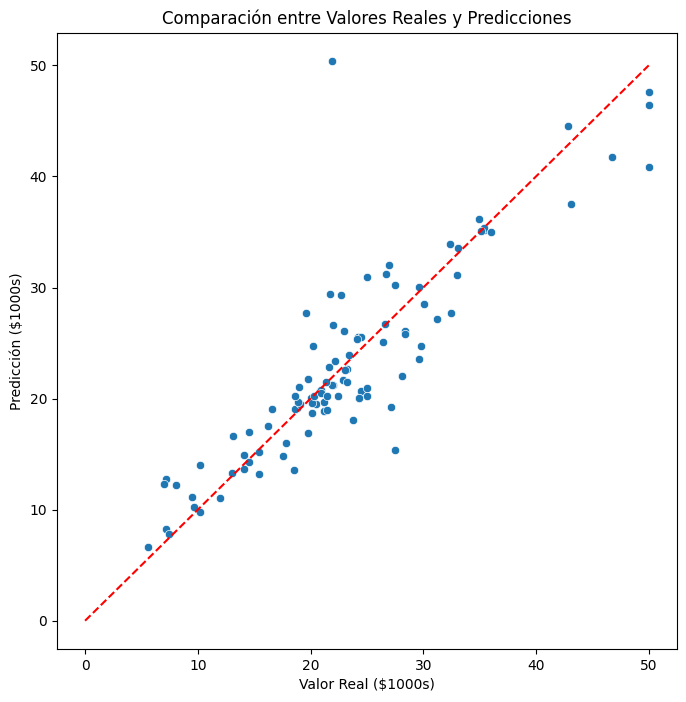

In [12]:
# Hacer predicciones con el modelo final
predictions = model.predict(test_data).flatten()

# Crear un DataFrame con los valores reales y las predicciones
df_results = pd.DataFrame({
    "Valor Real ($1000s)": test_targets,
    "Predicción ($1000s)": predictions
})

# Mostrar las primeras filas
print(df_results.head(10))

# Visualizar comparación real vs predicho
plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_results["Valor Real ($1000s)"], y=df_results["Predicción ($1000s)"])
plt.plot([0, 50], [0, 50], "--", color="red")  # Línea de referencia ideal
plt.xlabel("Valor Real ($1000s)")
plt.ylabel("Predicción ($1000s)")
plt.title("Comparación entre Valores Reales y Predicciones")
plt.show()
